In [1]:
import pygrib
import numpy as np
from numpy import fft
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
from datetime import datetime
import siphon
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.interpolate import log_interpolate_1d

In [2]:
yr = 2020
mo = 9
dy = 17
hr = 0
date = datetime(yr,mo,dy,hr)
#for FWD
station = 'FWD'
#lowest level above station elevation
zb = 200 #for FWD
zp_start = 300
#pressure at bottom of plot
ylim_b = 1000
#for FGZ
station='FGZ'
zb = 2200
#parcels starting elevation
zp_start= 2250
ylim_b = 900

#station = 'SLC'
#zb = 1290
#zp_start= 3000
#ylim_b = 900

df = WyomingUpperAir.request_data(date, station)
print(df.columns)
p = df['pressure'].values * units(df.units['pressure'])
t = df['temperature'].values * units(df.units['temperature'])
d = df['dewpoint'].values * units(df.units['dewpoint'])
z = df['height'].values * units(df.units['height'])
#print(pressure,temperature,height)

Index(['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed',
       'u_wind', 'v_wind', 'station', 'station_number', 'time', 'latitude',
       'longitude', 'elevation'],
      dtype='object')


FileNotFoundError: [Errno 2] No such file or directory: '../figs/skewt_FGZ_20209170.png'

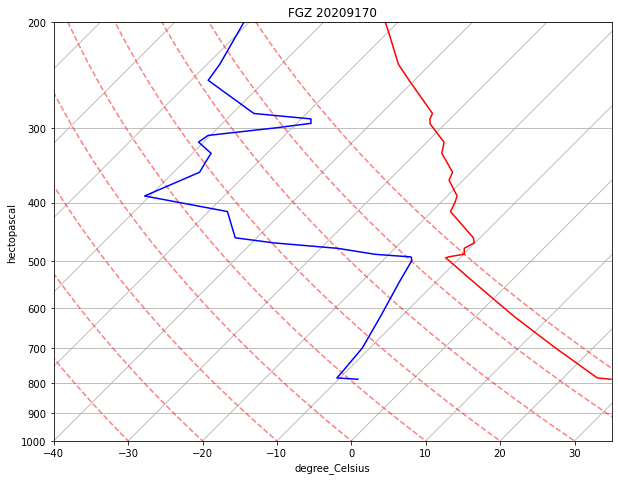

In [3]:
fig = plt.figure(figsize=(10, 8))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, t, 'r')
skew.plot(p,d,'b')

# Add the relevant special lines
skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
#skew.ax.set_ylim(900, 200)
skew.ax.set_ylim(1000, 200) #for FWD
skew.ax.set_xlim(-40, 35)

dat = str(yr)+str(mo)+str(dy)+str(hr)
skew.ax.set_title(station+' '+ dat)
plot_file = '../figs/skewt_'+station+'_'+ dat + '.png'
plt.savefig(plot_file)
plt.show()

In [4]:
#show parcel motion in a crude way

#adiabatic lapse rate in m
adl = 9.8/1000.
g = 9.8
rcp = .286

zz = z.m.astype(float)
te = t.m +273.16
pe = p.m
th = te * (1000./pe)**rcp
#print(th)

#interpolate to a 10m grid in the vertical
dz = 10.
zi = np.arange(zb+10,10000.,dz)
thz=log_interpolate_1d(zi, zz, th)
tz=log_interpolate_1d(zi, zz, te)
pz=log_interpolate_1d(zi, zz, pe)
nz=len(zi)
#print(thz)

#time interval (sec)
dt=1
#number of  time steps 
times = range(0,5001)

zp=np.empty_like(times).astype(float)
b=np.empty_like(times).astype(float)
N2=np.empty_like(times).astype(float)
wp=np.empty_like(times).astype(float)
thpd=np.empty_like(times).astype(float)
pp=np.empty_like(times).astype(float)

#starting height. then displace it by some incremental temp
zp[0] = zp_start 

#find the closest location in the vertical to the position
idx = (np.abs(zi - zp[0])).argmin()

#constant for adiabatic process. add 1C
thp = thz[idx] +1
#compute potential temp difference
thpd[0] = thp-thz[idx]
#compute buoyancy at that point
b[0] = (g/thz[idx])*(thpd[0])
#compute initial velocity
wp[0]=b[0]*dt
pp[0]=pz[idx]

print(0,idx,thpd[0],b[0],wp[0],zp[0],pp[0])    

#now iterate over other times
for im in times[1:]:
    time = dt*im
    im1 = im - 1
    #find the closest location in the vertical to the previous position
    idx = (np.abs(zi - zp[im1])).argmin()
    if idx<0:
        break
    if idx>nz:
        break
    thpd[im] = thp-thz[idx]
    #compute brunt-vaisala frequency at that point
    b[im] = (g/thz[idx])*(thpd[im])
    wp[im]=wp[im1]+b[im]*dt
    zp[im] = zp[im1]+wp[im]*dt
    pp[im] = pz[idx]
#    print(im,idx,thpd[im],b[im],wp[im],zp[im],pp[im])    
mtm = im

0 4 1.0 0.030710712494180333 0.030710712494180333 2250.0 783.664915863331


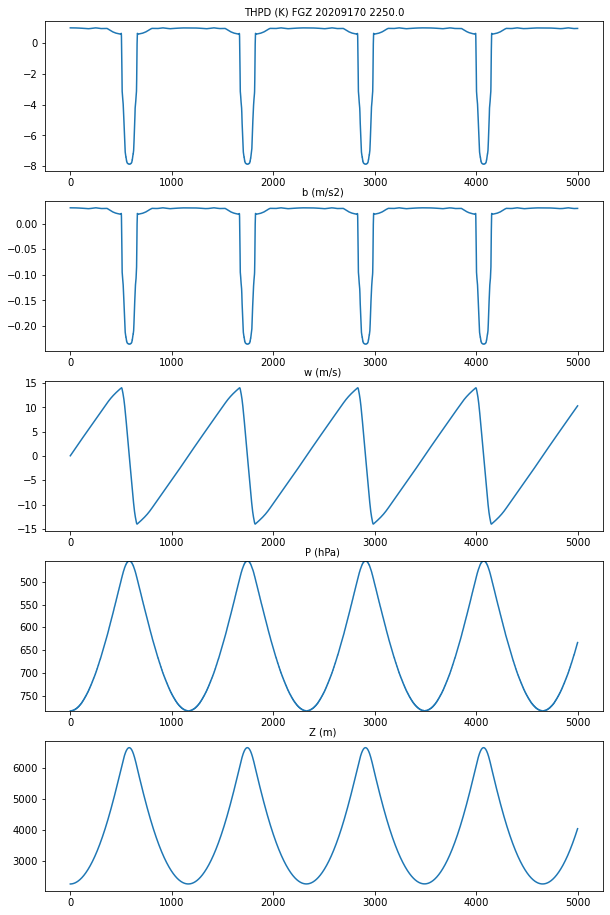

In [5]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(10,16))
ax5.plot(zp[:mtm])
ax5.set_title('Z (m) ',fontsize=10)
ax4.plot(pp[:mtm])
ax4.set_title('P (hPa) ',fontsize=10)
ax4.set_ylim(np.max(pp[:mtm]),np.min(pp[:mtm]))
ax3.plot(wp[:mtm])
ax3.set_title('w (m/s) ',fontsize=10)
ax2.plot(b[:mtm])
ax2.set_title('b (m/s2) ',fontsize=10)
ax1.plot(thpd[:mtm])
ax1.set_title('THPD (K) %s %s %s' % (station,dat,str(zp[0])),fontsize=10)
plot_file = '../figs/buoyancy_'+station+'_'+ dat + str(zp[0])+'.png'
plt.savefig(plot_file)
plt.show()

In [6]:
cape,cin=mpcalc.surface_based_cape_cin(p, t, d)
print('CAPE/CIN:',cape,cin)

CAPE/CIN: 0.0 joule / kilogram 0.0 joule / kilogram


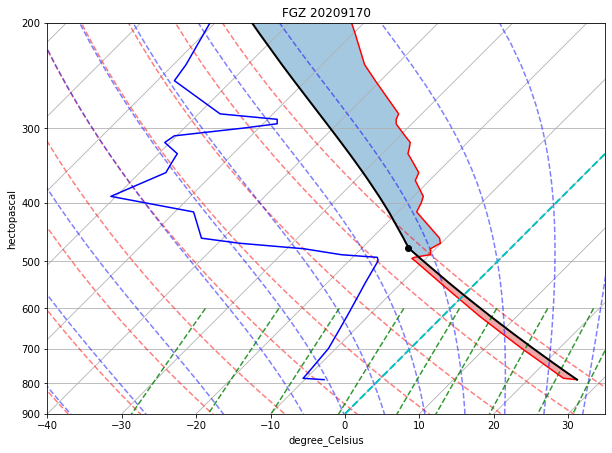

In [7]:
fig = plt.figure(figsize=(10, 8))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, t, 'r')
skew.plot(p,d,'b')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(ylim_b, 200)
#skew.ax.set_ylim(1000, 200) #for FWD
skew.ax.set_xlim(-40, 35)

# Calculate LCL height and plot as black dot. Because `p`'s first value is
#add 1C to initial temp
toff = 0
lclp, lclt = mpcalc.lcl(p[0], (t[0].m+toff)*units(df.units['temperature']), d[0])
skew.plot(lclp, lclt, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, (t[0].m+toff)*units(df.units['temperature']), d[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, t, prof)
skew.shade_cape(p, t, prof)


# 0C isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)


# Show the plot

skew.ax.set_title(station+' '+ dat)
plot_file = '../figs/parcel_'+station+'_'+ dat + '.png'
plt.savefig(plot_file)
plt.show()